# Example: Multioutput regression
---------------------------------

This example shows how to use ATOM to make preditions on a multioutput regression dataset. One of the models used is a MLP regressor implemented with [Keras](https://keras.io/) using [scikeras](https://www.adriangb.com/scikeras/refs/heads/master/index.html).

The data used is a synthetic dataset created using sklearn's [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) function.

## Load the data

In [1]:
# Disable annoying tf warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow import get_logger
get_logger().setLevel('ERROR')

import numpy as np
from atom import ATOMRegressor, ATOMModel
from sklearn.datasets import make_regression

from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Create data
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3)

In [3]:
# Create the neural network
class NeuralNetwork(KerasRegressor):
    """Multioutput multilayer perceptron."""

    def __repr__(self):
        return "NeuralNetwork()"

    @staticmethod
    def _keras_build_fn(n_inputs, n_outputs, **kwargs):
        """Create the model's architecture."""
        model = Sequential()
        model.add(Dense(20, input_dim=n_inputs, activation="relu"))
        model.add(Dense(20, activation="relu"))
        model.add(Dense(n_outputs))
        model.compile(loss="mse", optimizer="adam")
        return model

In [4]:
# Convert the model to an ATOM model
model = ATOMModel(
    estimator=NeuralNetwork(n_inputs=5, n_outputs=y.shape[1], epochs=100, verbose=0),
    name="NN",
    needs_scaling=True,  # Applies automated feature scaling before fitting
    native_multioutput=True,  # Do not use a multioutput meta-estimator wrapper
)

## Run the pipeline

In [5]:
atom = ATOMRegressor(X, y=y, verbose=2, random_state=1)

<< ================== ATOM ================== >>

Configuration ==================== >>
Algorithm task: Multioutput regression.

Dataset stats ==================== >>
Shape: (1000, 13)
Train set size: 800
Test set size: 200
-------------------------------------
Memory: 104.13 kB
Scaled: True
Outlier values: 29 (0.3%)



In [6]:
# Show the models that natively support multioutput tasks
atom.available_models(native_multioutput=True)

acronym                fullname                 estimator  \
0    Tree            DecisionTree     DecisionTreeRegressor   
1   ETree               ExtraTree        ExtraTreeRegressor   
2      ET              ExtraTrees       ExtraTreesRegressor   
3     KNN       KNearestNeighbors       KNeighborsRegressor   
4     RNN  RadiusNearestNeighbors  RadiusNeighborsRegressor   
5      RF            RandomForest     RandomForestRegressor   

                          module  handles_missing  needs_scaling  \
0          sklearn.tree._classes             True          False   
1          sklearn.tree._classes            False          False   
2       sklearn.ensemble._forest            False          False   
3  sklearn.neighbors._regression            False           True   
4  sklearn.neighbors._regression            False           True   
5       sklearn.ensemble._forest            False          False   

   accepts_sparse  native_multilabel  native_multioutput validation  \
0            True               True                True       None   
1            True               True                True       None   
2            True               True                True       None   
3            True               True                True       None   
4            True               True                True       None   
5            True               True                True       None   

           supports_engines  
0                   sklearn  
1                   sklearn  
2                   sklearn  
3  sklearn, sklearnex, cuml  
4                   sklearn  
5  sklearn, sklearnex, cuml

In [7]:
# Note we only added 5 informative features to the dataset, let's remove the rest
# If we use a model with no native support for multioutput as solver, specify the
# rfe's importance_getter parameter and return the mean of the coefficients over the
# target columns
atom.feature_selection(
    strategy="rfe",
    solver="ols",  # This becomes MultiOutputRegressor(OLS)
    n_features=5,
    importance_getter=lambda x: np.mean([e.coef_ for e in x.estimators_], axis=0),
)

Fitting FeatureSelector...
Performing feature selection ...
 --> rfe selected 5 features from the dataset.
   --> Dropping feature x0 (rank 5).
   --> Dropping feature x4 (rank 6).
   --> Dropping feature x5 (rank 2).
   --> Dropping feature x7 (rank 3).
   --> Dropping feature x9 (rank 4).


In [8]:
# Let's train a native, non-native and our custom model
atom.run(models=["Lasso", "RF", model], metric="mse", errors="raise")


Training ========================= >>
Models: Lasso, RF, NN
Metric: mse


Results for Lasso:
Fit ---------------------------------------------
Train evaluation --> mse: -4.6709
Test evaluation --> mse: -4.4039
Time elapsed: 0.031s
-------------------------------------------------
Time: 0.031s


Results for RandomForest:
Fit ---------------------------------------------
Train evaluation --> mse: -197.8132
Test evaluation --> mse: -1436.9264
Time elapsed: 0.385s
-------------------------------------------------
Time: 0.385s


Results for NeuralNetwork:
Fit ---------------------------------------------
Train evaluation --> mse: -113.9745
Test evaluation --> mse: -131.0996
Time elapsed: 4.949s
-------------------------------------------------
Time: 4.949s


Final results ==================== >>
Total time: 5.367s
-------------------------------------
Lasso         --> mse: -4.4039 !
RandomForest  --> mse: -1436.9264 ~
NeuralNetwork --> mse: -131.0996


In [9]:
# And check which of the models used a meta-estimator wrapper
for m in atom.models:
    print(f"Estimator for {m} is: {atom[m].estimator}")

Estimator for Lasso is: MultiOutputRegressor(estimator=Lasso(), n_jobs=1)
Estimator for RF is: RandomForestRegressor(n_jobs=1, random_state=1)
Estimator for NN is: NeuralNetwork()


## Analyze the results

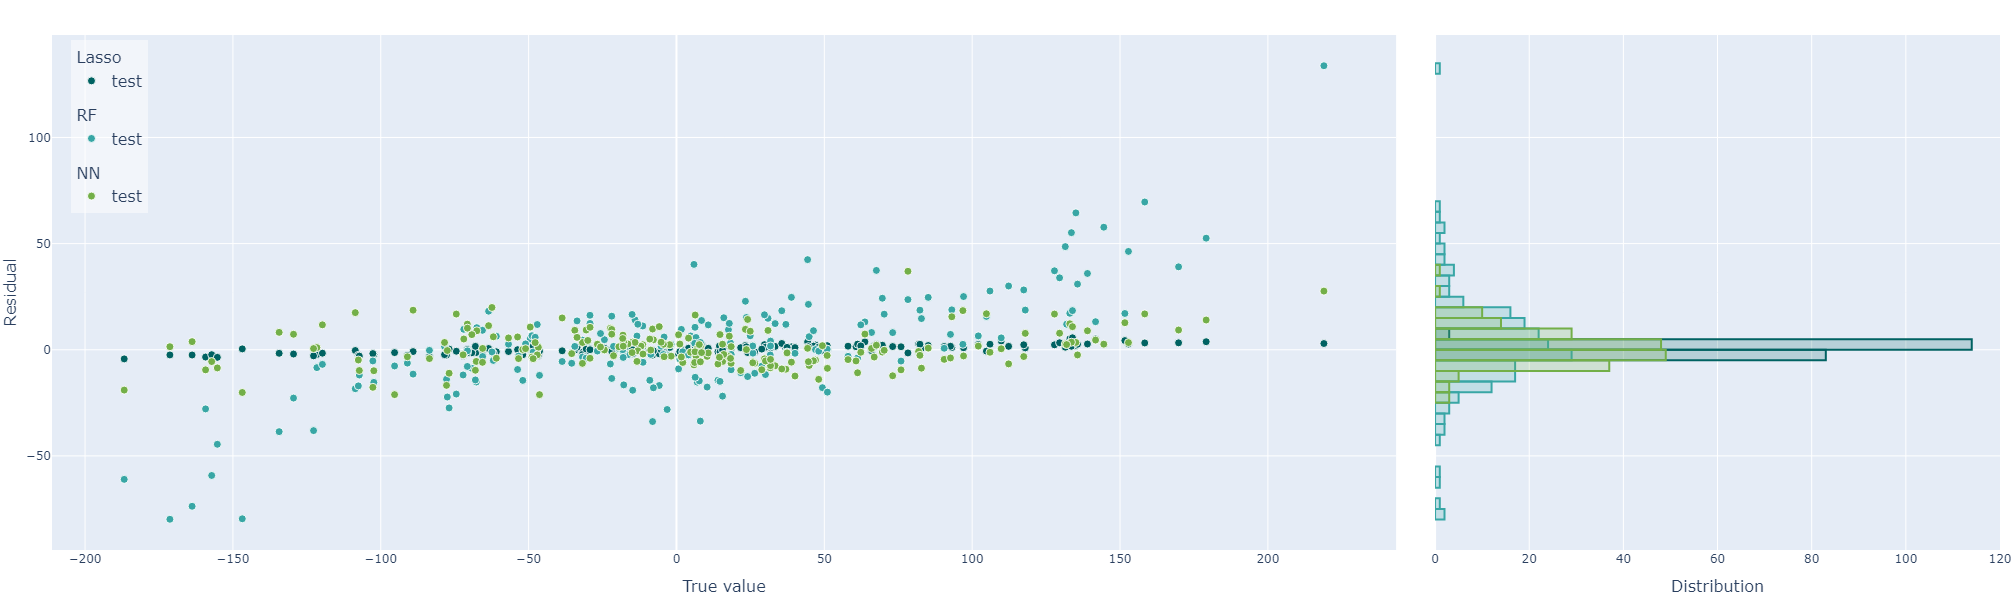

In [10]:
# Use the target parameter in plots to specify which target column to use
atom.plot_residuals(target=2)

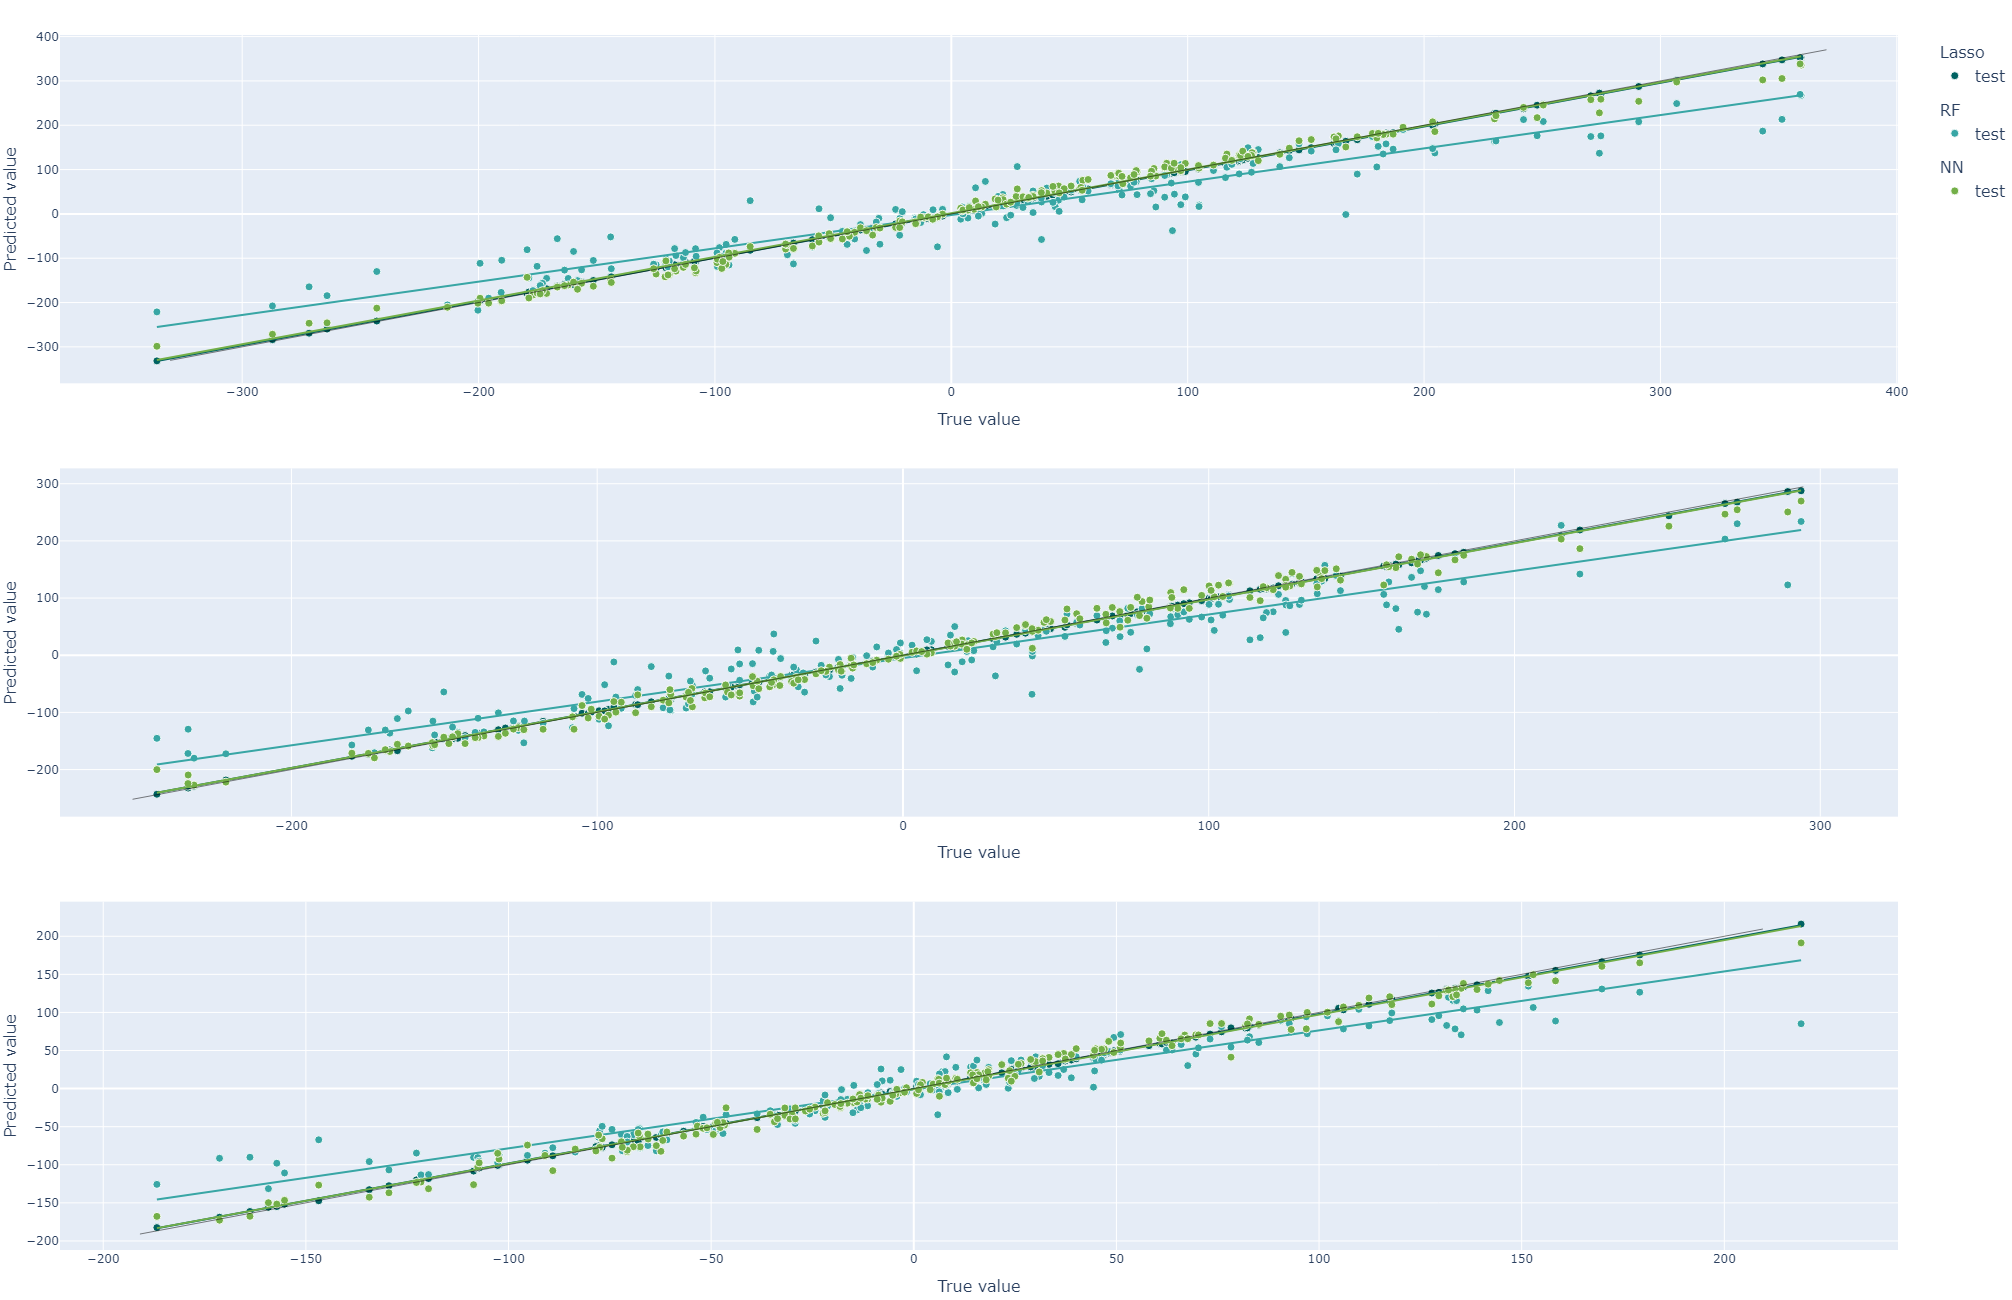

In [11]:
with atom.canvas(3, 1, figsize=(900, 1300)):
    atom.plot_errors(target=0)
    atom.plot_errors(target=1)
    atom.plot_errors(target=2)